In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV   # Logistic算法

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier   # KNN算法

In [4]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

##### 1、数据加载 + 异常数据处理

In [5]:
path = "datas/crx.data"
names = ['A1','A2','A3','A4','A5','A6','A7','A8',
         'A9','A10','A11','A12','A13','A14','A15','A16']
df = pd.read_csv(path, header=None, names=names)
print ("数据条数:", len(df))

df = df.replace("?", np.nan).dropna(how='any')
print ("过滤后数据条数:", len(df))

df.head(5)

数据条数: 690
过滤后数据条数: 653


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [6]:
df.A5.value_counts()

g     499
p     152
gg      2
Name: A5, dtype: int64

In [7]:
# 自定义的一个哑编码实现方式：将v变量转换成为一个list集合的形式
def parse(value, list1):
    # value是一个字符串，需要进行转换的数据
    # list1是一个类别信息，value是list1中的一个值
    return [1 if i == value else 0 for i in list1]   # 对于每一个向量，匹配上v时为该数据为1，其他为0。
                        # 先执行后面的代码，再执行if

def parseRecord(record):
    result = []
    ## 格式化数据，将离线数据转换为连续数据
    a1 = record['A1']
    for i in parse(a1, ('a', 'b')):
        result.append(i)
    
    result.append(float(record['A2']))
    result.append(float(record['A3']))
    
    # 将A4的信息转换为哑编码的形式; 对于DataFrame中，原来一列的数据现在需要四列来进行表示
    a4 = record['A4']
    for i in parse(a4, ('u', 'y', 'l', 't')):
        result.append(i)
    
    a5 = record['A5']
    for i in parse(a5, ('g', 'p', 'gg')):
        result.append(i)
    
    a6 = record['A6']
    for i in parse(a6, ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')):
        result.append(i)
    
    a7 = record['A7']
    for i in parse(a7, ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')):
        result.append(i)
    
    result.append(float(record['A8']))
    
    a9 = record['A9']
    for i in parse(a9, ('t', 'f')):
        result.append(i)
        
    a10 = record['A10']
    for i in parse(a10, ('t', 'f')):
        result.append(i)
    
    result.append(float(record['A11']))
    
    a12 = record['A12']
    for i in parse(a12, ('t', 'f')):
        result.append(i)
        
    a13 = record['A13']
    for i in parse(a13, ('g', 'p', 's')):
        result.append(i)
    
    result.append(float(record['A14']))
    result.append(float(record['A15']))
    
    a16 = record['A16']
    if a16 == '+':
        result.append(1)
    else:
        result.append(0)
        
    return result

In [8]:
### 数据特征处理(将数据转换为数值类型的)
new_names =  ['A1_0', 'A1_1',
              'A2',
              'A3',
              'A4_0','A4_1','A4_2','A4_3', # 对A4进行哑编码操作后，就会使用四列来表示一列的值
              'A5_0', 'A5_1', 'A5_2', 
              'A6_0', 'A6_1', 'A6_2', 'A6_3', 'A6_4', 'A6_5', 'A6_6', 'A6_7', 'A6_8', 'A6_9', 'A6_10', 'A6_11', 'A6_12', 'A6_13', 
              'A7_0', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 
              'A8',
              'A9_0', 'A9_1' ,
              'A10_0', 'A10_1',
              'A11',
              'A12_0', 'A12_1',
              'A13_0', 'A13_1', 'A13_2',
              'A14','A15','A16']
datas = df.apply(lambda x: pd.Series(parseRecord(x), index = new_names), axis=1)
names = new_names

## 展示一下处理后的数据
datas.head(5)

,A1_0,A1_1,A2,A3,A4_0,A4_1,A4_2,A4_3,A5_0,A5_1,...,A10_1,A11,A12_0,A12_1,A13_0,A13_1,A13_2,A14,A15,A16
0,0.0,1.0,30.83,0.000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,202.0,0.0,1.0
1,1.0,0.0,58.67,4.460,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,6.0,0.0,1.0,1.0,0.0,0.0,43.0,560.0,1.0
2,1.0,0.0,24.50,0.500,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,280.0,824.0,1.0
3,0.0,1.0,27.83,1.540,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,1.0,0.0,1.0,0.0,0.0,100.0,3.0,1.0
4,0.0,1.0,20.17,5.625,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.0,1.0


In [9]:
X = datas[names[0:-1]]   # 第1列到倒数第二列
Y = datas[names[-1]]   # 最后一列

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)   # X分割后依然是DataFrame类型，Y依然是Series类型

In [10]:
X_train.describe().T      # 查看数据情况 —— describe() 是Dataframe 属性

,count,mean,std,min,25%,50%,75%,max
A1_0,587.0,0.315162,0.464977,0.00,0.000,0.00,1.000,1.00
A1_1,587.0,0.684838,0.464977,0.00,0.000,1.00,1.000,1.00
A2,587.0,31.685417,11.883506,13.75,22.625,28.67,38.290,76.75
A3,587.0,4.909319,5.073588,0.00,1.040,3.00,7.520,28.00
A4_0,587.0,0.761499,0.426530,0.00,1.000,1.00,1.000,1.00
A4_1,587.0,0.235094,0.424419,0.00,0.000,0.00,0.000,1.00
A4_2,587.0,0.003407,0.058321,0.00,0.000,0.00,0.000,1.00
A4_3,587.0,0.000000,0.000000,0.00,0.000,0.00,0.000,0.00
A5_0,587.0,0.761499,0.426530,0.00,1.000,1.00,1.000,1.00
A5_1,587.0,0.235094,0.424419,0.00,0.000,0.00,0.000,1.00


##### 数据正则化操作(归一化)

In [16]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)   # 归一化后的 X_Train 是一个 numpy.ndarray 类型
X_test = ss.transform(X_test)

[[-0.67837969  0.67837969 -0.50663061 ... -0.30179143 -0.11010036
  -0.18593372]
 [-0.67837969  0.67837969  0.20167659 ... -0.30179143  1.54240973
  -0.18593372]
 [-0.67837969  0.67837969 -0.70371014 ... -0.30179143 -0.11010036
  -0.12684205]
 ...
 [-0.67837969  0.67837969  1.38836486 ... -0.30179143 -1.04438168
  -0.03032567]
 [-0.67837969  0.67837969  0.01217704 ... -0.30179143 -1.04438168
  -0.18593372]
 [-0.67837969  0.67837969 -0.42240859 ... -0.30179143 -0.11010036
   0.95197477]]


In [17]:
pd.DataFrame(X_train).describe().T   # 查看数据情况

,count,mean,std,min,25%,50%,75%,max
0,587.0,3.442259e-17,1.000853,-0.678380,-0.678380,-0.678380,1.474101,1.474101
1,587.0,-3.442259e-17,1.000853,-1.474101,-1.474101,0.678380,0.678380,0.678380
2,587.0,1.881894e-17,1.000853,-1.510557,-0.763087,-0.253965,0.556251,3.795430
3,587.0,1.078070e-17,1.000853,-0.968448,-0.763290,-0.376646,0.515002,4.555036
4,587.0,5.976669e-17,1.000853,-1.786857,0.559642,0.559642,0.559642,0.559642
5,587.0,8.548906e-17,1.000853,-0.554391,-0.554391,-0.554391,-0.554391,1.803780
6,587.0,2.397287e-17,1.000853,-0.058471,-0.058471,-0.058471,-0.058471,17.102631
7,587.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,587.0,5.976669e-17,1.000853,-1.786857,0.559642,0.559642,0.559642,0.559642
9,587.0,8.548906e-17,1.000853,-0.554391,-0.554391,-0.554391,-0.554391,1.803780


##### Logistic算法模型构建 + 训练

In [19]:
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='ovr')
lr.fit(X_train, Y_train)

C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=array([1.00000e-04, 1.26486e-04, 1.59986e-04, 2.02359e-04, 2.55955e-04,
       3.23746e-04, 4.09492e-04, 5.17947e-04, 6.55129e-04, 8.28643e-04,
       1.04811e-03, 1.32571e-03, 1.67683e-03, 2.12095e-03, 2.68270e-03,
       3.39322e-03, 4.29193e-03, 5.42868e-03, 6.86649e-03, 8.68511e-03,
       1...., 2.44205e+00, 3.08884e+00,
       3.90694e+00, 4.94171e+00, 6.25055e+00, 7.90604e+00, 1.00000e+01]),
           class_weight=None, cv='warn', dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=None, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.01, verbose=0)

##### 模型效果获取

In [22]:
print ("Logistic算法R值（准确率）：", lr.score(X_train, Y_train))
print ("Logistic算法稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print ("Logistic算法参数：",lr.coef_)
print ("Logistic算法截距：",lr.intercept_)

Logistic算法R值（准确率）： 0.8909710391822828
Logistic算法稀疏化特征比率：2.13%
Logistic算法参数： [[-0.00507672  0.00507672  0.06367298  0.06284643  0.03997945 -0.04935683
   0.06679464  0.          0.03997945 -0.04935683  0.06679464  0.00549457
  -0.02646873  0.1057865  -0.10294239 -0.02346199 -0.05981958 -0.0131902
   0.01148842  0.04690591  0.03631018  0.13996153  0.03858644 -0.02422956
  -0.11817039 -0.00441403  0.08130739 -0.02489682  0.03130081  0.03567533
  -0.01396069 -0.00769375 -0.10417126 -0.00379776  0.15834772  0.46892613
  -0.46892613  0.16546747 -0.16546747  0.19117654 -0.01273762  0.01273762
   0.01240825 -0.00744574 -0.0110668  -0.08907636  0.12989149]]
Logistic算法截距： [-0.25992008]


##### 数据预测

In [29]:
Y_predict = lr.predict(X_test)
print(Y_predict)
print(Y_predict.shape)
print()

Y_predict_probe = lr.predict_proba(X_test)
print(Y_predict_probe)   # [0,1]各自的概率

[1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.]
(66,)

[[0.22855228 0.77144772]
 [0.18260146 0.81739854]
 [0.15724948 0.84275052]
 [0.8701438  0.1298562 ]
 [0.47949865 0.52050135]
 [0.05541409 0.94458591]
 [0.75895994 0.24104006]
 [0.21888948 0.78111052]
 [0.88715054 0.11284946]
 [0.34023558 0.65976442]
 [0.05851845 0.94148155]
 [0.91466856 0.08533144]
 [0.85372992 0.14627008]
 [0.16044605 0.83955395]
 [0.46888191 0.53111809]
 [0.85338146 0.14661854]
 [0.14325521 0.85674479]
 [0.55315686 0.44684314]
 [0.93684193 0.06315807]
 [0.19932811 0.80067189]
 [0.9559255  0.0440745 ]
 [0.89619766 0.10380234]
 [0.87028753 0.12971247]
 [0.77272228 0.22727772]
 [0.81332938 0.18667062]
 [0.69657062 0.30342938]
 [0.81158919 0.18841081]
 [0.46436477 0.53563523]
 [0.25327843 0.74672157]
 [0.85623504 0.14376496]
 [0.92428097 0.07571903]
 [0.24865346 0.7

### KNN算法

In [24]:
## 1、构建 + 训练
knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree', weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')

In [30]:
## 2、模型评估
print("Logistic算法R值（准确率）：%.2f" % knn.score(X_train, Y_train))

Logistic算法R值（准确率）：1.00


In [31]:
## 3、模型预测
knn_y_predict = knn.predict(X_test)

##### 绘制图形

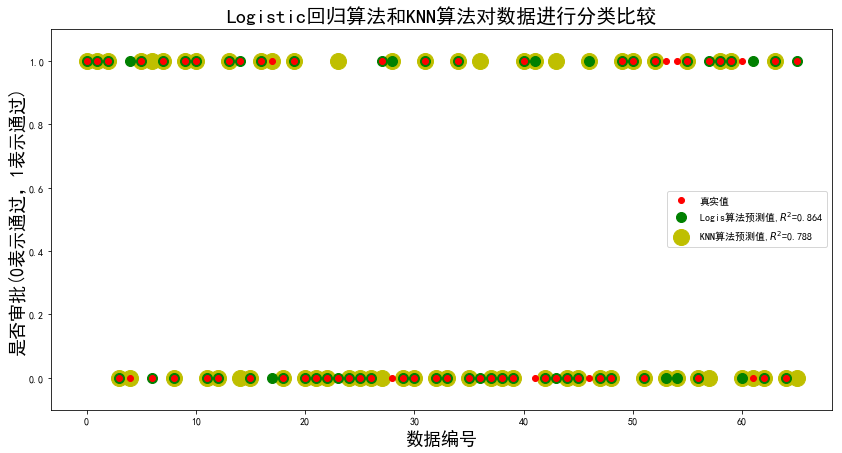

In [28]:
x_len = range(len(X_test))

plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-0.1,1.1)
plt.plot(x_len, Y_test, 'ro',markersize = 6, zorder=3, label='真实值')
plt.plot(x_len, Y_predict, 'go', markersize = 10, zorder=2, label='Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label='KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'center right')

plt.xlabel('数据编号', fontsize=18)
plt.ylabel('是否审批(0表示通过，1表示通过)', fontsize=18)
plt.title('Logistic回归算法和KNN算法对数据进行分类比较', fontsize=20)
plt.show()